In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json
import pickle
import pandas as pd
from suicide_data import SuicideDataset
from torch.utils.data import  DataLoader
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import numpy as np
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from utils import sketch,precision_recall_f1,accuracy_cal,map_to_labels
import copy
from model.attention_bilstm import BiLSTM_Attention
from model.lstm import SentimentLSTM
from model.rnn import SentimentRNN
from model.gru import GRU
from model.cnn import CNN

Load configuration,data,pretrained embeddings


In [2]:
# Load configuration file
with open('config.json', 'r') as config_file:
    config = json.load(config_file)
    lstm_config = config['LSTM']
    bilstm_config = config['BiLSTM_Attention']
    rnn_config = config['RNN']
    gru_config = config['GRU']
    cnn_config = config['CNN']

In [3]:
#Load training data
train_df = pd.read_csv("data/train_data.csv")
#Load validation data
val_df = pd.read_csv("data/val_data.csv")
#Load tokenizer object
with open("embeddings/tokenizer.json", "r") as f:
    tokenizer_json = json.load(f)
    tokenizer = tokenizer_from_json(tokenizer_json)
with open("embeddings/CBOW_embeddings.pkl" , "rb") as cbow:
    cbow_embeddings = pickle.load(cbow)
with open("embeddings/SkipGram_embeddings.pkl" , "rb") as sg:
    sg_embeddings = pickle.load(sg)

In [4]:
trainset = SuicideDataset(texts = train_df["cleaned_text"], labels = train_df["class"], tokenizer = tokenizer)
valset = SuicideDataset(val_df["cleaned_text"], val_df["class"], tokenizer)
train_loader = DataLoader(trainset, batch_size= 64,shuffle=True,drop_last=True)
val_loader = DataLoader(valset, batch_size=64, shuffle=True, drop_last=True)

In [5]:
VOCAB_SIZE=len(tokenizer.index_word)+1
# Load the pre-trained Word2Vec model (e.g., Google News vectors)
w2v_model = Word2Vec(sentences=common_texts, vector_size=300, window=5, min_count=1, workers=4)
embedding_dim = w2v_model.vector_size  
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
#Creating thw embedding_matrix based on W2V model in gensim
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]  
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))  

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load model and Experimental results


Common train function for all model experiments

In [7]:
def train(model, train_loader, val_loader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss().to(device)

    train_losses = []
    val_losses = []

    train_accs = []
    val_accs = []

    train_f1s = []
    val_f1s = []

    # Track best metrics
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    best_metrics = []  # List to store all the best metrics in one place

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        total_train_f1 = 0

        # Training phase
        for step, (batch_embeddings, batch_labels) in enumerate(train_loader):
            optimizer.zero_grad()
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

            tag_scores = model(batch_embeddings)
            loss = criterion(tag_scores, batch_labels.float())
            total_train_loss += loss.item()

            acc = accuracy_cal(tag_scores, batch_labels.float())
            total_train_acc += acc

            f1 = precision_recall_f1(tag_scores, batch_labels.float())[2]
            total_train_f1 += f1

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)
        avg_train_f1 = total_train_f1 / len(train_loader)

        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        train_f1s.append(avg_train_f1)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        total_val_f1 = 0

        with torch.no_grad():
            for batch_embeddings, batch_labels in val_loader:
                batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
                val_outputs = model(batch_embeddings)

                val_loss = criterion(val_outputs, batch_labels.float())
                total_val_loss += val_loss.item()

                val_acc = accuracy_cal(val_outputs, batch_labels.float())
                total_val_acc += val_acc

                val_f1 = precision_recall_f1(val_outputs, batch_labels.float())[2]
                total_val_f1 += val_f1

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)
        avg_val_f1 = total_val_f1 / len(val_loader)

        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)
        val_f1s.append(avg_val_f1)

        # Update best metrics if current validation loss is better
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            best_model_state = copy.deepcopy(model.state_dict())
            best_metrics = [
                best_epoch, avg_train_loss, best_val_loss,
                avg_train_acc, avg_val_acc,
                avg_train_f1, avg_val_f1
            ]

        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
              f'Train Accuracy: {avg_train_acc:.4f}%, Val Accuracy: {avg_val_acc:.4f}%, '
              f'Train F1-Score: {avg_train_f1:.4f}%, Val F1-Score: {avg_val_f1:.4f}%')

    # Load the best model state
    model.load_state_dict(best_model_state)
    print("\nTraining complete!")

    print(f"Best Model at Epoch {best_metrics[0]}: "
          f"Train Loss: {best_metrics[1]:.4f}, Val Loss: {best_metrics[2]:.4f}, "
          f"Train Accuracy: {best_metrics[3]:.4f}%, Val Accuracy: {best_metrics[4]:.4f}%, "
          f"Train F1-Score: {best_metrics[5]:.4f}%, Val F1-Score: {best_metrics[6]:.4f}%")

    return train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s


# RNN

RNN without preprocessing model

In [33]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config['epochs'],rnn_config['learning_rate'])
sketch("RNN without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

RNN with CBOW model

In [ ]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate'],
    pretrained_embeddings=  cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config['epochs'],rnn_config['learning_rate'])
sketch("RNN with CBOW model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

RNN with Skip Gram model

In [ ]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate'],
    pretrained_embeddings=  sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config['epochs'],rnn_config['learning_rate'])
sketch("RNN with SkipGram model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

RNN with pretrained W2V in Gensim

In [ ]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate'],
    pretrained_embeddings = embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config['epochs'],rnn_config['learning_rate'])
sketch("RNN with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# LSTM

LSTM without preprocessing model

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,lstm_config['epochs'],lstm_config['learning_rate'])
sketch("LSTM without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

LSTM with CBOW

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate'],
    pretrained_embeddings= cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,lstm_config['epochs'],lstm_config['learning_rate'])
sketch("LSTM with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

LSTM with SKipGram

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate'],
    pretrained_embeddings= sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,lstm_config['epochs'],lstm_config['learning_rate'])
sketch("LSTM with SkipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

LSTM with pretrained W2V in Gensim

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate'],
    pretrained_embeddings=embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,lstm_config['epochs'],lstm_config['learning_rate'])
sketch("LSTM with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# Bi-LSTM with Attenion Layer


BI-LSTM_Attention without preprocessing model


In [ ]:
model =BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,bilstm_config['epochs'],bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

BI-LSTM_Attention with CBOW

In [ ]:
model =BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate'],
    pretrained_embeddings=cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,bilstm_config['epochs'],bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

BI-LSTM_Attention with SKipGram

In [ ]:
model =BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate'],
    pretrained_embeddings=sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,bilstm_config['epochs'],bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention with SKipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

BI-LSTM_Attention with pretrained W2V in Gensim

In [ ]:
model =BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate'],
    pretrained_embeddings=embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,bilstm_config['epochs'],bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# GRU

GRU without preprocessing model

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,gru_config['epochs'],gru_config['learning_rate'])
sketch("GRU without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

GRU with CBOW

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate'],
    pretrained_embeddings= cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,gru_config['epochs'],gru_config['learning_rate'])
sketch("GRU with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

GRU with SKipGram

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate'],
    pretrained_embeddings= sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,gru_config['epochs'],gru_config['learning_rate'])
sketch("GRU with SKipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

GRU with pretrained W2V in Gensim

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate'],
    pretrained_embeddings= embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,gru_config['epochs'],gru_config['learning_rate'])
sketch("GRU with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# CNN

CNN without preprocessing model

Epoch [1/15], Train Loss: 0.3157, Val Loss: 0.2338, Train Accuracy: 0.8684%, Val Accuracy: 0.9087%, Train F1-Score: 0.8656%, Val F1-Score: 0.9061%
Epoch [2/15], Train Loss: 0.2355, Val Loss: 0.2125, Train Accuracy: 0.9083%, Val Accuracy: 0.9192%, Train F1-Score: 0.9064%, Val F1-Score: 0.9176%
Epoch [3/15], Train Loss: 0.2098, Val Loss: 0.2038, Train Accuracy: 0.9192%, Val Accuracy: 0.9227%, Train F1-Score: 0.9175%, Val F1-Score: 0.9217%
Epoch [4/15], Train Loss: 0.1926, Val Loss: 0.1987, Train Accuracy: 0.9264%, Val Accuracy: 0.9245%, Train F1-Score: 0.9250%, Val F1-Score: 0.9232%
Epoch [5/15], Train Loss: 0.1793, Val Loss: 0.1958, Train Accuracy: 0.9323%, Val Accuracy: 0.9256%, Train F1-Score: 0.9311%, Val F1-Score: 0.9248%
Epoch [6/15], Train Loss: 0.1676, Val Loss: 0.1948, Train Accuracy: 0.9371%, Val Accuracy: 0.9275%, Train F1-Score: 0.9357%, Val F1-Score: 0.9270%
Epoch [7/15], Train Loss: 0.1556, Val Loss: 0.1929, Train Accuracy: 0.9413%, Val Accuracy: 0.9281%, Train F1-Score: 0.

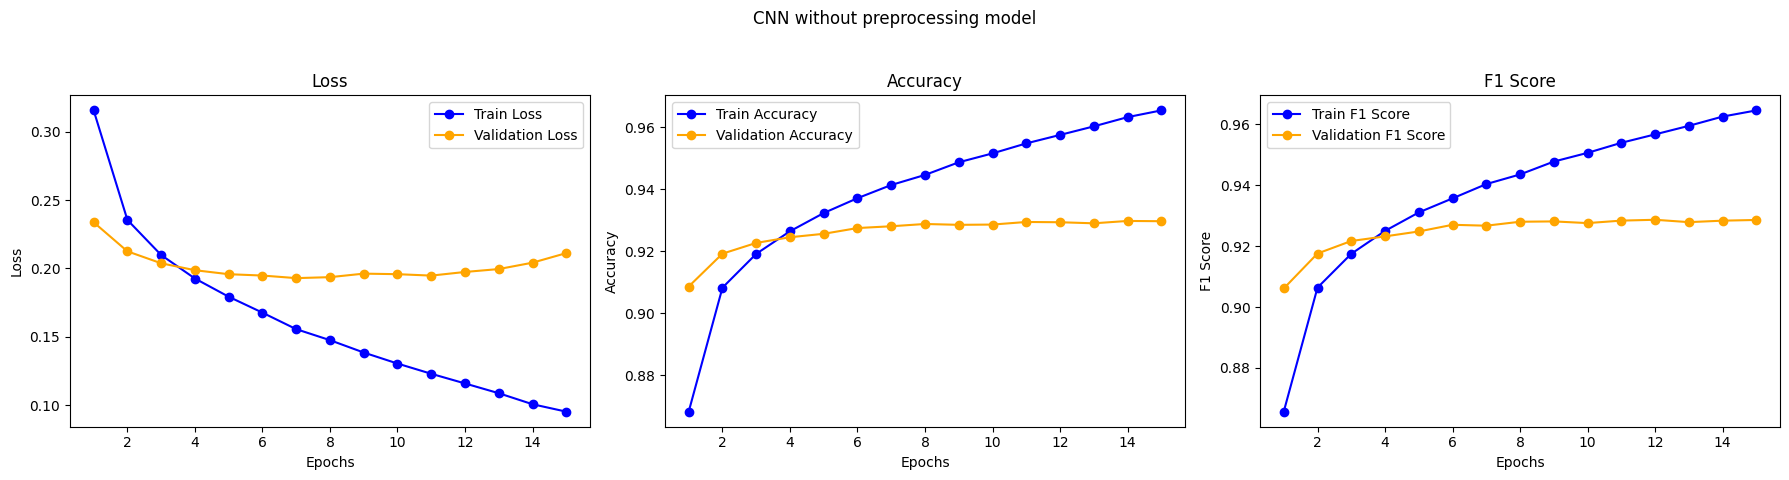

In [8]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

CNN with CBOW

Epoch [1/15], Train Loss: 0.3234, Val Loss: 0.2129, Train Accuracy: 0.8619%, Val Accuracy: 0.9187%, Train F1-Score: 0.8626%, Val F1-Score: 0.9174%
Epoch [2/15], Train Loss: 0.2056, Val Loss: 0.1961, Train Accuracy: 0.9215%, Val Accuracy: 0.9254%, Train F1-Score: 0.9204%, Val F1-Score: 0.9249%
Epoch [3/15], Train Loss: 0.1889, Val Loss: 0.1918, Train Accuracy: 0.9285%, Val Accuracy: 0.9267%, Train F1-Score: 0.9275%, Val F1-Score: 0.9261%
Epoch [4/15], Train Loss: 0.1782, Val Loss: 0.1888, Train Accuracy: 0.9335%, Val Accuracy: 0.9280%, Train F1-Score: 0.9323%, Val F1-Score: 0.9271%
Epoch [5/15], Train Loss: 0.1691, Val Loss: 0.1883, Train Accuracy: 0.9367%, Val Accuracy: 0.9284%, Train F1-Score: 0.9355%, Val F1-Score: 0.9273%
Epoch [6/15], Train Loss: 0.1619, Val Loss: 0.1910, Train Accuracy: 0.9397%, Val Accuracy: 0.9269%, Train F1-Score: 0.9387%, Val F1-Score: 0.9267%
Epoch [7/15], Train Loss: 0.1545, Val Loss: 0.1916, Train Accuracy: 0.9427%, Val Accuracy: 0.9269%, Train F1-Score: 0.

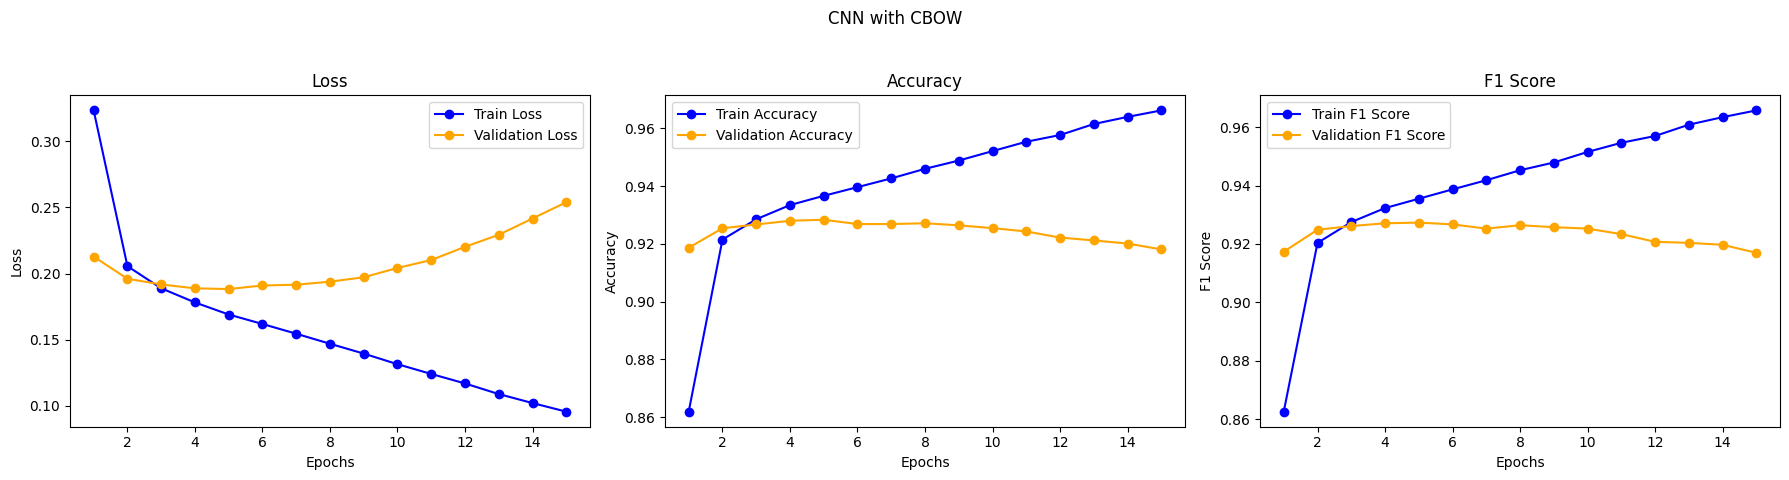

In [8]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
    embedding_matrix= cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

CNN with SkipGram

Epoch [1/15], Train Loss: 0.3332, Val Loss: 0.2261, Train Accuracy: 0.8613%, Val Accuracy: 0.9133%, Train F1-Score: 0.8584%, Val F1-Score: 0.9137%
Epoch [2/15], Train Loss: 0.2126, Val Loss: 0.2010, Train Accuracy: 0.9196%, Val Accuracy: 0.9235%, Train F1-Score: 0.9183%, Val F1-Score: 0.9233%
Epoch [3/15], Train Loss: 0.1927, Val Loss: 0.1911, Train Accuracy: 0.9273%, Val Accuracy: 0.9272%, Train F1-Score: 0.9261%, Val F1-Score: 0.9265%
Epoch [4/15], Train Loss: 0.1818, Val Loss: 0.1905, Train Accuracy: 0.9321%, Val Accuracy: 0.9271%, Train F1-Score: 0.9310%, Val F1-Score: 0.9270%
Epoch [5/15], Train Loss: 0.1732, Val Loss: 0.1870, Train Accuracy: 0.9355%, Val Accuracy: 0.9288%, Train F1-Score: 0.9344%, Val F1-Score: 0.9280%
Epoch [6/15], Train Loss: 0.1658, Val Loss: 0.1867, Train Accuracy: 0.9385%, Val Accuracy: 0.9288%, Train F1-Score: 0.9375%, Val F1-Score: 0.9274%
Epoch [7/15], Train Loss: 0.1600, Val Loss: 0.1866, Train Accuracy: 0.9406%, Val Accuracy: 0.9296%, Train F1-Score: 0.

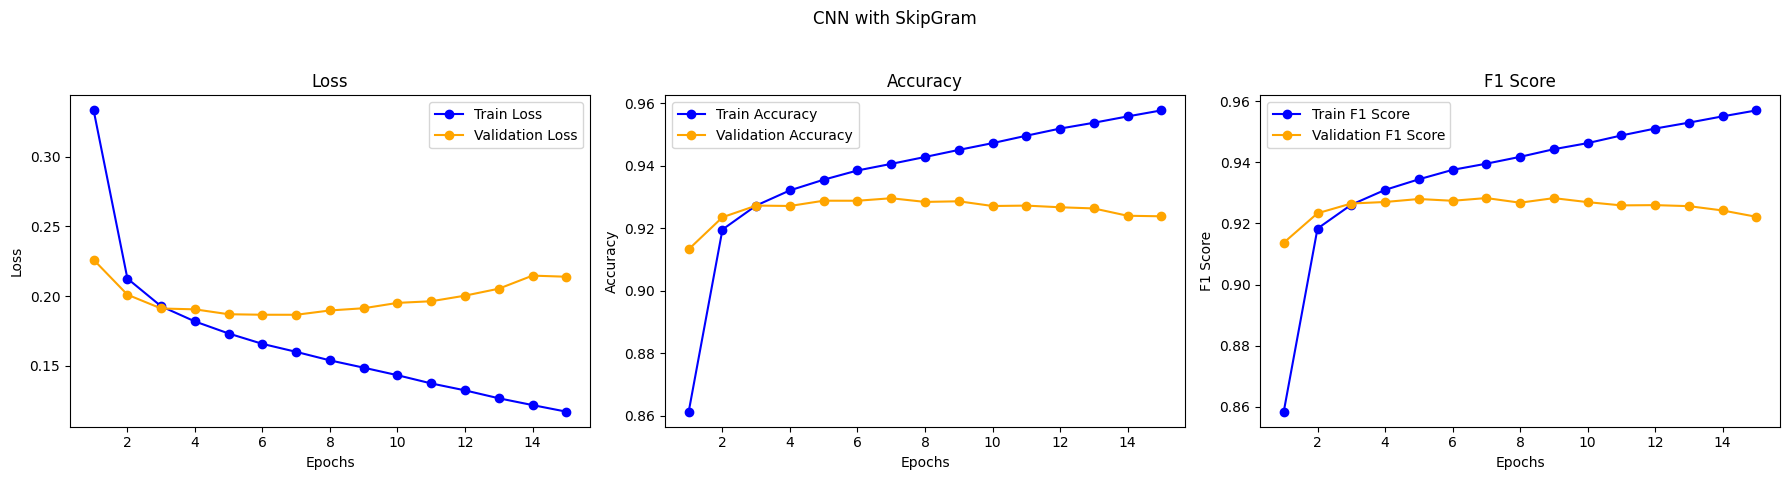

In [9]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
    embedding_matrix= sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN with SkipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

CNN with pretrained W2V in Gensim

Epoch [1/15], Train Loss: 0.3120, Val Loss: 0.2280, Train Accuracy: 0.8701%, Val Accuracy: 0.9123%, Train F1-Score: 0.8706%, Val F1-Score: 0.9104%
Epoch [2/15], Train Loss: 0.2243, Val Loss: 0.2079, Train Accuracy: 0.9138%, Val Accuracy: 0.9200%, Train F1-Score: 0.9120%, Val F1-Score: 0.9195%
Epoch [3/15], Train Loss: 0.1986, Val Loss: 0.1967, Train Accuracy: 0.9244%, Val Accuracy: 0.9246%, Train F1-Score: 0.9231%, Val F1-Score: 0.9227%
Epoch [4/15], Train Loss: 0.1804, Val Loss: 0.1923, Train Accuracy: 0.9315%, Val Accuracy: 0.9273%, Train F1-Score: 0.9304%, Val F1-Score: 0.9259%
Epoch [5/15], Train Loss: 0.1659, Val Loss: 0.1891, Train Accuracy: 0.9378%, Val Accuracy: 0.9285%, Train F1-Score: 0.9367%, Val F1-Score: 0.9272%
Epoch [6/15], Train Loss: 0.1548, Val Loss: 0.1889, Train Accuracy: 0.9418%, Val Accuracy: 0.9288%, Train F1-Score: 0.9408%, Val F1-Score: 0.9274%
Epoch [7/15], Train Loss: 0.1435, Val Loss: 0.1899, Train Accuracy: 0.9470%, Val Accuracy: 0.9294%, Train F1-Score: 0.

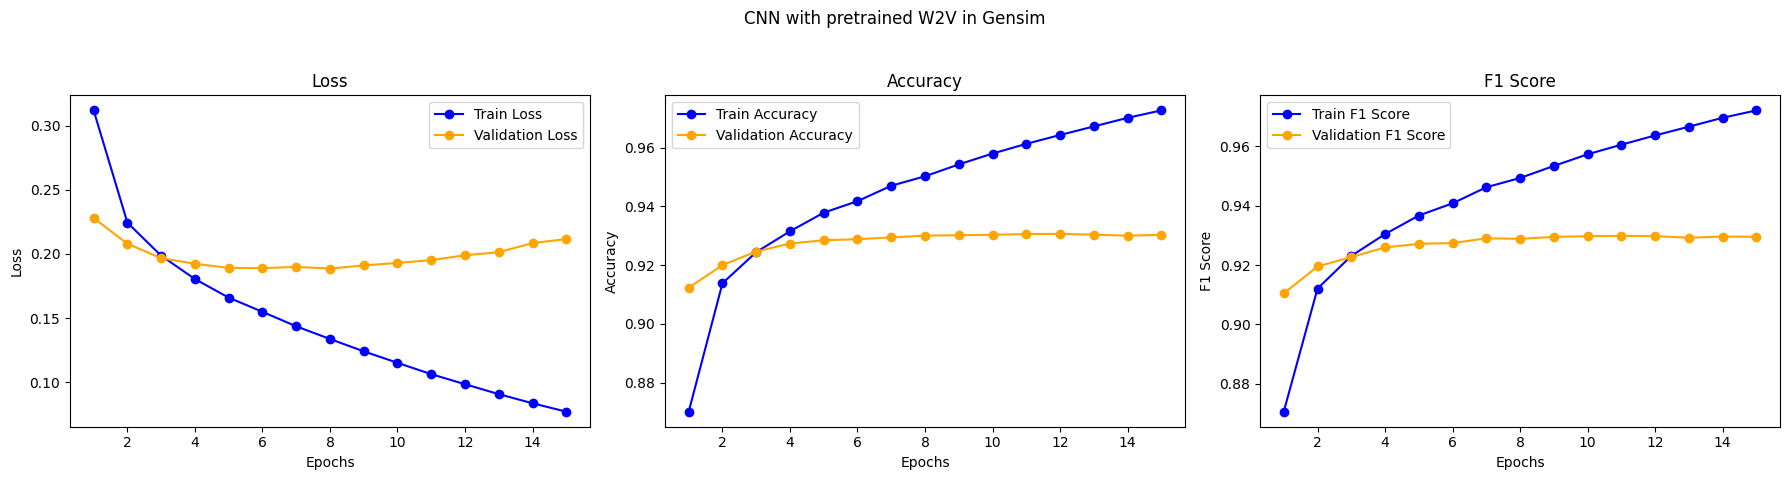

In [10]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
    embedding_matrix= embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)